# Métodos Generalizados Multidimensionais

Neste notebook apresentamos uma implementação para o NSGA-II e outra para o NSGA-III com entradas de parâmetros generalizadas para experimentos com multiplos objetivos.

## Implementação NSGA-II

In [1]:
import numpy as np
import random

def nsga2(pop_size, generations, bounds, functions):
    """
    NSGA-II generalizado para N dimensões.

    :param pop_size: Tamanho da população
    :param generations: Número de gerações
    :param bounds: Lista de tuplas [(min1, max1), (min2, max2), ...] definindo os limites para cada dimensão
    :param functions: Lista de funções objetivo [f1, f2, ..., fM]
    :return: Fronteira de Pareto da última geração
    """

    n_dimensions = len(bounds)

    # Inicialização da população
    def initialize_population(size, bounds):
        return [
            np.array([random.uniform(b[0], b[1]) for b in bounds])
            for _ in range(size)
        ]

    # Avaliação da população
    def evaluate_population(population, functions):
        return [tuple(f(x) for f in functions) for x in population]

    # Dominância
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Ordenação não-dominada (Implementação NSGA-II)
    def fast_nondominated_sort(objectives):
        fronts = [[]]
        domination_count = [0] * len(objectives)
        dominated_solutions = [[] for _ in range(len(objectives))]

        for p in range(len(objectives)):
            for q in range(len(objectives)):
                if dominates(objectives[p], objectives[q]):
                    dominated_solutions[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    domination_count[p] += 1

            if domination_count[p] == 0:
                fronts[0].append(p)

        i = 0
        while len(fronts[i]) > 0:
            next_front = []
            for p in fronts[i]:
                for q in dominated_solutions[p]:
                    domination_count[q] -= 1
                    if domination_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        fronts.pop()
        return fronts

    # Cruzamento
    def crossover(parent1, parent2):
        return (parent1 + parent2) / 2

    # Mutação
    def mutation(individual, bounds, mutation_rate=0.5):
        if random.random() < mutation_rate:
            for i in range(len(individual)):
                individual[i] += random.uniform(-0.1, 0.1)
                individual[i] = np.clip(individual[i], bounds[i][0], bounds[i][1])
        return individual

    # Distância de crowding
    def crowding_distance(front, objectives):
        if len(front) == 1:
            return [float('inf')]
        
        distances = [0] * len(front)
        for m in range(len(objectives[0])):
            sorted_front = sorted(range(len(front)), key=lambda i: objectives[front[i]][m])
            distances[sorted_front[0]] = distances[sorted_front[-1]] = float('inf')
            for i in range(1, len(front) - 1):
                distances[sorted_front[i]] += (
                    objectives[front[sorted_front[i + 1]]][m] - objectives[front[sorted_front[i - 1]]][m]
                )
        return distances

    # Seleção com elitismo
    def select_next_population(fronts, objectives, population, pop_size):
        next_population = []
        for front in fronts:
            if len(next_population) + len(front) <= pop_size:
                next_population.extend(front)
            else:
                distances = crowding_distance(front, objectives)
                sorted_front = sorted(zip(front, distances), key=lambda x: x[1], reverse=True)
                next_population.extend([solution for solution, _ in sorted_front[:pop_size - len(next_population)]])
                break
        return [population[i] for i in next_population]  # Seleciona os indivíduos correspondentes

    # Inicializa a população
    population = initialize_population(pop_size, bounds)

    for gen in range(generations):
        # Avaliação
        objectives = evaluate_population(population, functions)

        # Ordenação não-dominada
        fronts = fast_nondominated_sort(objectives)

        # Visualização no final
        if gen == generations - 1:
            pareto_front = [objectives[i] for i in fronts[0]]
            pareto_front.sort()

        # Nova geração
        new_population = []
        while len(new_population) < pop_size:
            # Seleção de dois pais
            parent1, parent2 = random.sample(population, 2)

            # Cruzamento
            child = crossover(parent1, parent2)

            # Mutação
            child = mutation(child, bounds)

            new_population.append(child)
            
        # Combinar pais e descendentes
        combined_population = population + new_population
        combined_objectives = evaluate_population(combined_population, functions)
        
        # Realizar nova ordenação não-dominada
        combined_fronts = fast_nondominated_sort(combined_objectives)
        
        # Selecionar próxima geração com elitismo
        population = select_next_population(combined_fronts, combined_objectives, combined_population, pop_size)

    return pareto_front


## Implementação NSGA-III

In [2]:
import numpy as np
import random
from collections import defaultdict

def nsga3(pop_size, generations, bounds, functions, base_mutation_rate=0.1, divisions=4):
    """
    NSGA-III generalizado para N dimensões.

    :param pop_size: Tamanho da população
    :param generations: Número de gerações
    :param bounds: Lista de tuplas [(min1, max1), (min2, max2), ...] definindo os limites para cada dimensão
    :param functions: Lista de funções objetivo [f1, f2, ..., fM]
    :param base_mutation_rate: Taxa de mutação base
    :param divisions: Número de divisões para geração dos pontos de referência
    :return: Fronteira de Pareto da última geração
    """

    def initialize_population(size, bounds):
        return [
            np.array([random.uniform(b[0], b[1]) for b in bounds])
            for _ in range(size)
        ]

    def evaluate_population(population, functions):
        return [tuple(f(x) for f in functions) for x in population]

    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    def fast_nondominated_sort(objectives):
        population_size = len(objectives)
        S = [[] for _ in range(population_size)]
        n = [0] * population_size
        rank = [0] * population_size
        fronts = [[]]

        for p in range(population_size):
            for q in range(population_size):
                if dominates(objectives[p], objectives[q]):
                    S[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    n[p] += 1
            if n[p] == 0:
                rank[p] = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in S[p]:
                    n[q] -= 1
                    if n[q] == 0:
                        rank[q] = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        fronts.pop()
        return fronts

    def generate_reference_points(M, p):
        def generate_recursive(points, num_objs, left, total, depth, current_point):
            if depth == num_objs - 1:
                current_point.append(left / total)
                points.append(current_point.copy())
                current_point.pop()
            else:
                for i in range(left + 1):
                    current_point.append(i / total)
                    generate_recursive(points, num_objs, left - i, total, depth + 1, current_point)
                    current_point.pop()
        points = []
        generate_recursive(points, M, p, p, 0, [])
        return np.array(points)

    def environmental_selection(population, objectives, fronts, reference_points, pop_size):
        next_population_indices = []
        for front in fronts:
            if len(next_population_indices) + len(front) <= pop_size:
                next_population_indices.extend(front)
            else:
                N = pop_size - len(next_population_indices)
                selected_indices = niching_selection(front, objectives, reference_points, N)
                next_population_indices.extend(selected_indices)
                break
        next_population = [population[i] for i in next_population_indices]
        return next_population

    def niching_selection(front, objectives, reference_points, N):
        selected = []
        objs = np.array([objectives[i] for i in front])
        ideal_point = np.min(objs, axis=0)
        normalized_objs = objs - ideal_point

        max_values = np.max(normalized_objs, axis=0)
        max_values[max_values == 0] = 1
        normalized_objs = normalized_objs / max_values

        associations = []
        for idx, obj in zip(front, normalized_objs):
            distances = np.linalg.norm(obj - reference_points, axis=1)
            min_index = np.argmin(distances)
            associations.append((idx, min_index, distances[min_index]))

        reference_associations = defaultdict(list)
        for idx, ref_idx, dist in associations:
            reference_associations[ref_idx].append((idx, dist))

        niche_counts = {i: 0 for i in range(len(reference_points))}
        selected_flags = {idx: False for idx in front}

        while len(selected) < N:
            min_niche_count = min(niche_counts.values())
            min_refs = [ref for ref, count in niche_counts.items() if count == min_niche_count]

            for ref_idx in min_refs:
                assoc_inds = reference_associations.get(ref_idx, [])
                unselected_inds = [(idx, dist) for idx, dist in assoc_inds if not selected_flags[idx]]

                if unselected_inds:
                    unselected_inds.sort(key=lambda x: x[1])
                    selected_idx = unselected_inds[0][0]
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                    niche_counts[ref_idx] += 1
                    break
            else:
                remaining = [idx for idx in front if not selected_flags[idx]]
                if remaining:
                    selected_idx = random.choice(remaining)
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                else:
                    break

        return selected[:N]

    def compute_individual_ranks(fronts):
        individual_ranks = {}
        for rank, front in enumerate(fronts):
            for idx in front:
                individual_ranks[idx] = rank
        return individual_ranks

    def tournament_selection(population, individual_ranks):
        i1, i2 = random.sample(range(len(population)), 2)
        rank1 = individual_ranks[i1]
        rank2 = individual_ranks[i2]
        if rank1 < rank2:
            return population[i1]
        elif rank2 < rank1:
            return population[i2]
        else:
            return population[random.choice([i1, i2])]

    def crossover(parent1, parent2):
        w = random.uniform(0, 1)
        return w * parent1 + (1 - w) * parent2

    def mutation(individual, bounds, mutation_rate):
        if random.random() < mutation_rate:
            for i in range(len(individual)):
                individual[i] += random.uniform(-0.1, 0.1)
                individual[i] = np.clip(individual[i], bounds[i][0], bounds[i][1])
        return individual

    population = initialize_population(pop_size, bounds)
    M = len(functions)
    reference_points = generate_reference_points(M, divisions)

    for gen in range(generations):
        objectives = evaluate_population(population, functions)
        fronts = fast_nondominated_sort(objectives)
        individual_ranks = compute_individual_ranks(fronts)

        offspring_population = []
        while len(offspring_population) < pop_size:
            parent1 = tournament_selection(population, individual_ranks)
            parent2 = tournament_selection(population, individual_ranks)
            child = crossover(parent1, parent2)
            mutation_rate = base_mutation_rate * (1 - gen / generations)
            child = mutation(child, bounds, mutation_rate)
            offspring_population.append(child)

        combined_population = population + offspring_population
        combined_objectives = evaluate_population(combined_population, functions)
        combined_fronts = fast_nondominated_sort(combined_objectives)
        population = environmental_selection(combined_population, combined_objectives, combined_fronts, reference_points, pop_size)

    objectives = evaluate_population(population, functions)
    fronts = fast_nondominated_sort(objectives)
    pareto_front = [objectives[i] for i in fronts[0]]
    pareto_front.sort()

    return pareto_front


## Funções para Testes

In [3]:
# Funções de exemplo para o caso com 2 objetivos
def func1_2d(x):
    return x[0]**2

def func2_2d(x):
    return (x[0] - 2)**2

# Caso com 2 objetivos
bounds_2d = [(-5, 5)]
functions_2d = [func1_2d, func2_2d]

In [4]:
# Funções de exemplo para o caso com 3 objetivos
def func1_3d(x):
    return x[0]**2 + x[1]**2

def func2_3d(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2

def func3_3d(x):
    return (x[0] - 2)**2 + (x[1] - 2)**2

# Caso com 3 objetivos
bounds_3d = [(-5, 5), (-5, 5)]
functions_3d = [func1_3d, func2_3d, func3_3d]

## Testes

In [5]:
import matplotlib.pyplot as plt

def plot_solutions(points1, points2):
    # Normalizar os valores dos objetivos para [0, 1]
    def normalize(solutions):
        return (solutions - solutions.min(axis=0)) / (solutions.max(axis=0) - solutions.min(axis=0))

    sorted_points1 = sorted(points1, key=lambda point: abs(point[0]))
    sorted_points2 = sorted(points2, key=lambda point: abs(point[0]))
    
    solutions1 = np.array(sorted_points1)
    solutions2 = np.array(sorted_points2)

    normalized_solutions1 = normalize(solutions1)
    normalized_solutions2 = normalize(solutions2)

    # Configuração dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Plot do primeiro conjunto de soluções
    for sol in normalized_solutions1:
        axes[0].plot(np.arange(solutions1.shape[1]), sol, marker='o', alpha=0.7)
    axes[0].set_xticks(np.arange(solutions1.shape[1]))
    axes[0].set_xticklabels([f"Objetivo {i+1}" for i in range(solutions1.shape[1])])
    axes[0].set_xlabel("Objetivos")
    axes[0].set_ylabel("Valores Normalizados")
    axes[0].set_title("Conjunto de Soluções 2D")
    axes[0].grid(alpha=0.3)

    # Plot do segundo conjunto de soluções
    for sol in normalized_solutions2:
        axes[1].plot(np.arange(solutions2.shape[1]), sol, marker='o', alpha=0.7)
    axes[1].set_xticks(np.arange(solutions2.shape[1]))
    axes[1].set_xticklabels([f"Objetivo {i+1}" for i in range(solutions2.shape[1])])
    axes[1].set_xlabel("Objetivos")
    axes[1].set_title("Conjunto de Soluções 3D")
    axes[1].grid(alpha=0.3)

    # Ajustar layout
    plt.tight_layout()
    plt.show()

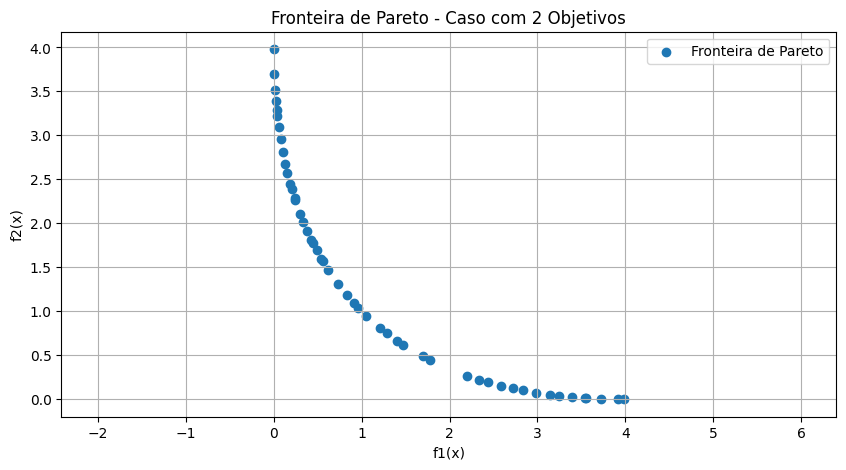

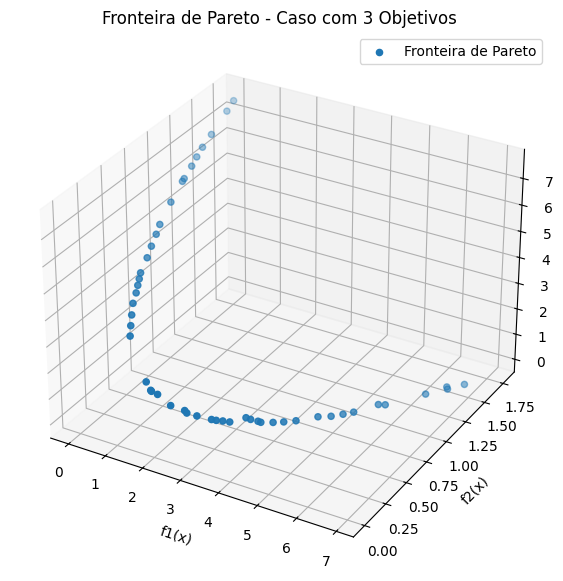

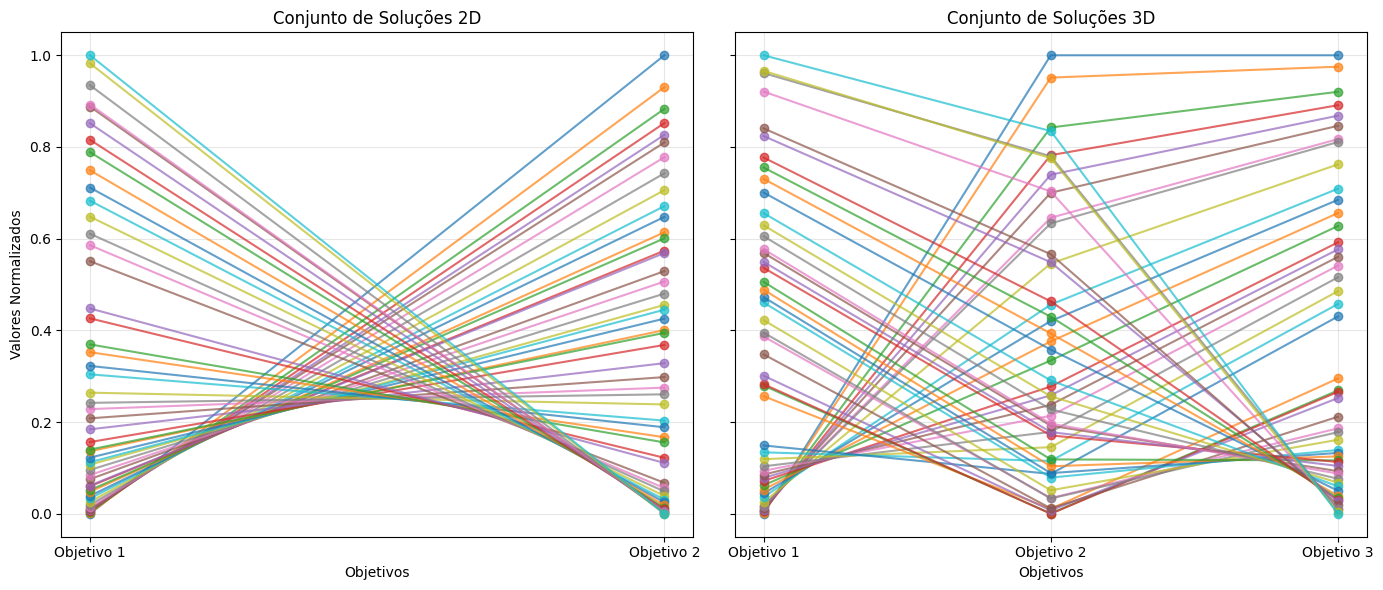

In [6]:
import matplotlib.pyplot as plt

# Caso com 2 objetivos
pareto_front_2d = nsga2(pop_size=50, generations=10, bounds=bounds_2d, functions=functions_2d)

# Caso com 3 objetivos
pareto_front_3d = nsga2(pop_size=50, generations=10, bounds=bounds_3d, functions=functions_3d)

# Plot para 2 objetivos
plt.figure(figsize=(10, 5))
plt.scatter(*zip(*pareto_front_2d), label='Fronteira de Pareto')
plt.title('Fronteira de Pareto - Caso com 2 Objetivos')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()

# Plot para 3 objetivos
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*pareto_front_3d), label='Fronteira de Pareto')
ax.set_title('Fronteira de Pareto - Caso com 3 Objetivos')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')
ax.set_zlabel('f3(x)')
ax.legend()
plt.show()

plot_solutions(pareto_front_2d, pareto_front_3d)

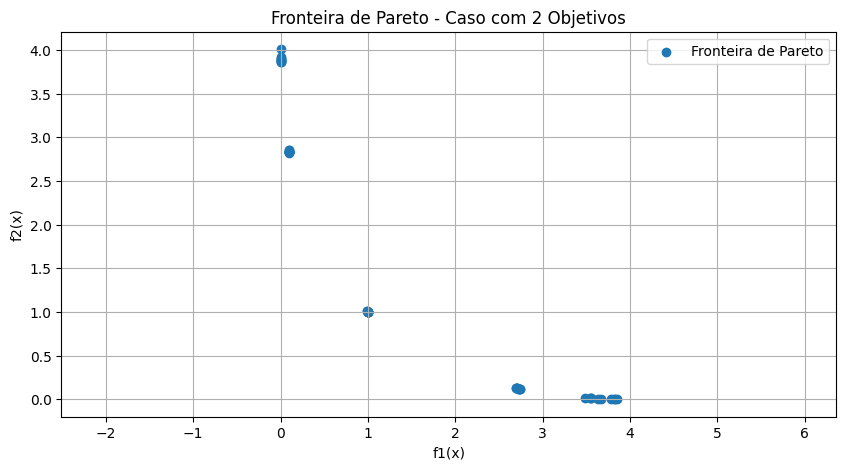

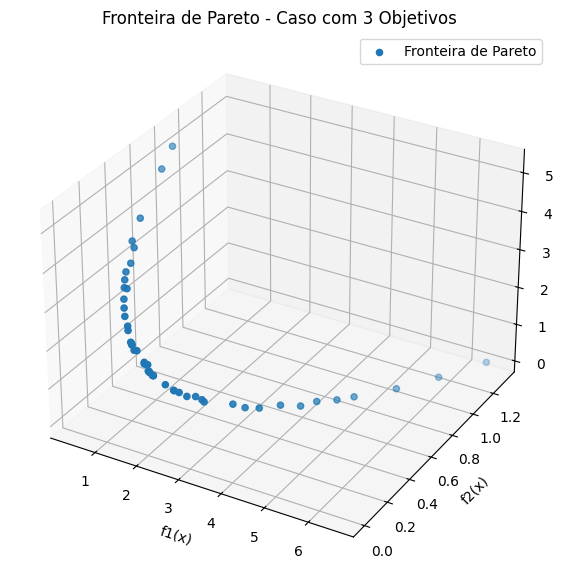

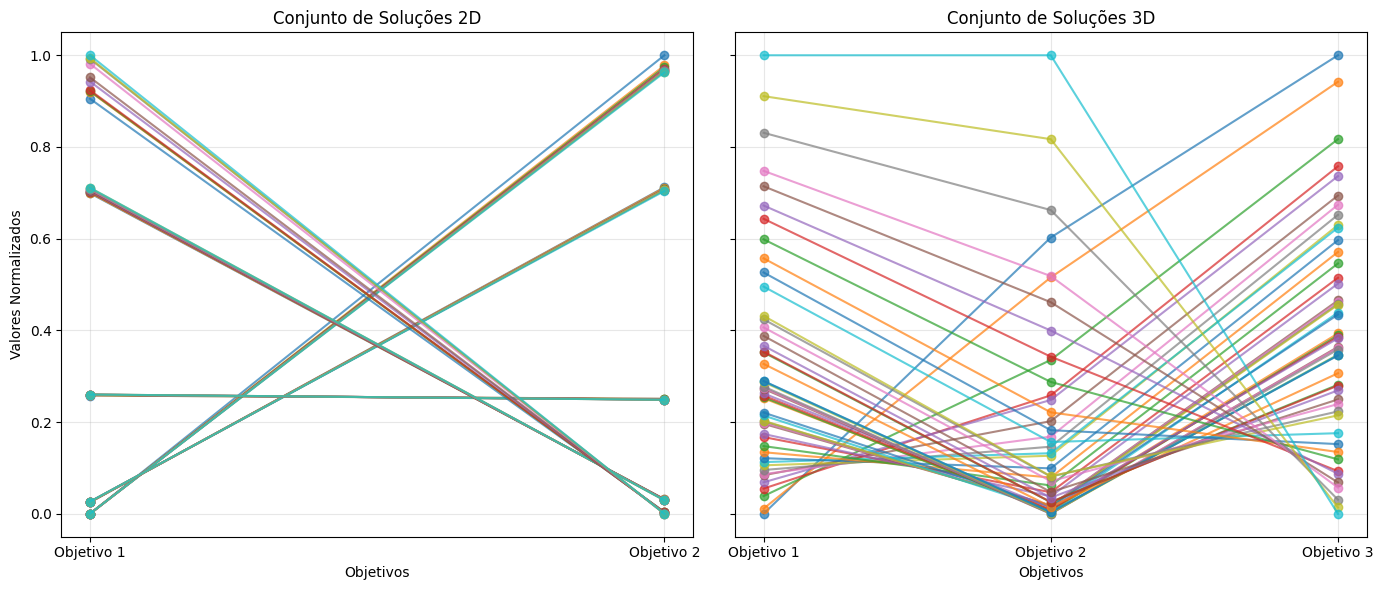

In [7]:
import matplotlib.pyplot as plt

# Caso com 2 objetivos
pareto_front_2d = nsga3(pop_size=50, generations=10, bounds=bounds_2d, functions=functions_2d)

# Caso com 3 objetivos
pareto_front_3d = nsga3(pop_size=50, generations=10, bounds=bounds_3d, functions=functions_3d)

# Plot para 2 objetivos
plt.figure(figsize=(10, 5))
plt.scatter(*zip(*pareto_front_2d), label='Fronteira de Pareto')
plt.title('Fronteira de Pareto - Caso com 2 Objetivos')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()

# Plot para 3 objetivos
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*zip(*pareto_front_3d), label='Fronteira de Pareto')
ax.set_title('Fronteira de Pareto - Caso com 3 Objetivos')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')
ax.set_zlabel('f3(x)')
ax.legend()
plt.show()

plot_solutions(pareto_front_2d, pareto_front_3d)